In [80]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_palette(["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

import lightgbm as lgb

#from pdpbox import pdp
import shap
shap.initjs()

import gc

In [81]:
data = pd.read_csv('../data/All_ProfileAnalysis_noBG_transposed.csv', index_col=0).T.reset_index().rename(columns={'index': 'ID'})
meta = pd.read_csv('../data/metadata_GNPS.csv', sep='\t').rename(columns={'filename': 'ID'})

In [82]:
data.ID = data.ID.apply(lambda x: x[-x[::-1].find('_'):-2])
meta.ID = meta.ID.apply(lambda x: x[:x.find('.')])

### Preprocessing

A look at the data.

In [83]:
data.head()

,ID,2.10min : 285.279m/z,2.56min : 427.117m/z,2.77min : 723.173m/z,2.77min : 246.074m/z,2.78min : 164.071m/z,2.79min : 206.081m/z,2.79min : 224.092m/z,2.79min : 121.064m/z,2.85min : 180.102m/z,...,21.25min : 802.631m/z,21.25min : 893.713m/z,21.25min : 811.602m/z,21.25min : 265.252m/z,21.25min : 659.526m/z,21.25min : 678.462m/z,21.25min : 444.338m/z,21.25min : 811.711m/z,21.25min : 881.671m/z,21.25min : 770.565m/z
0,25050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The metadata.

In [84]:
meta.sample(10)

,ID,ATTRIBUTE_Control,ATTRIBUTE_Experiment,ATTRIBUTE_Parasite,ATTRIBUTE_Gut_section,ATTRIBUTE_Timepoint,ATTRIBUTE_HPLC-MS
12,24954,NaN,inf,T. cruzi tryp,AM,1.0,20.0
271,25041,ACN,NaN,NaN,NaN,NaN,NaN
174,25144,NaN,inf,T. rangeli tryp,PM,0.0,182.0
175,25145,NaN,inf,T. rangeli tryp,H,0.0,183.0
158,25106,Non-Inf,NaN,T. cruzi epi,AM,3.0,166.0
230,25203,Non-Inf,NaN,T. rangeli tryp,AM,4.0,238.0
69,25022,Non-Inf,NaN,T. cruzi tryp,H,3.0,77.0
213,25185,Non-Inf,NaN,T. rangeli tryp,PM,0.0,221.0
8,24949,NaN,inf,T. cruzi tryp,H,0.0,16.0
244,25218,PBS3,NaN,NaN,NaN,NaN,252.0


We see that only non-infected insects appear in the `control` column, having missing values in `experiment`, and viceversa. We can then simply merge these two columns to create a target.

The label for infected is interpreted as infinite, so we change that.

In [85]:
data_tagged = data.merge(meta, how='left').replace(np.inf, 'infected')

There is one row with all missing values, so we remove it

In [86]:
data_tagged = data_tagged.drop(data_tagged[data_tagged[['ATTRIBUTE_Control', 'ATTRIBUTE_Experiment']].isna().all(axis=1)].index.values, axis=0)

In [87]:
exps = data_tagged['ATTRIBUTE_Experiment'].values
ctrls = data_tagged['ATTRIBUTE_Control'].values

status = []
for i, x in enumerate(exps):
    status.append(x if type(x)==str else ctrls[i])

data_tagged['status'] = status

In [88]:
data_tagged = data_tagged.drop(['ATTRIBUTE_Control', 'ATTRIBUTE_Experiment', 'ATTRIBUTE_Parasite'],axis=1)

A single table with all compound data + metadata and label

In [89]:
data_tagged.sample(10)

,ID,2.10min : 285.279m/z,2.56min : 427.117m/z,2.77min : 723.173m/z,2.77min : 246.074m/z,2.78min : 164.071m/z,2.79min : 206.081m/z,2.79min : 224.092m/z,2.79min : 121.064m/z,2.85min : 180.102m/z,...,21.25min : 659.526m/z,21.25min : 678.462m/z,21.25min : 444.338m/z,21.25min : 811.711m/z,21.25min : 881.671m/z,21.25min : 770.565m/z,ATTRIBUTE_Gut_section,ATTRIBUTE_Timepoint,ATTRIBUTE_HPLC-MS,status
157,25208,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,H,7.0,243.0,Non-Inf
10,24942,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,H,0.0,10.0,infected
15,25117,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,H,2.0,114.0,infected
198,25000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,AM,1.0,58.0,Non-Inf
50,25082,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,PM,1.0,146.0,Non-Inf
162,25213,0.0,0.0,0.0,0.0,0.0,0.0,8736.946204,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,PM,7.0,248.0,Non-Inf
116,25169,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1154.020352,0.0,0.0,PM,7.0,206.0,infected
36,25067,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,AM,0.0,133.0,Non-Inf
104,25158,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,H,2.0,195.0,infected
92,25146,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,AM,0.0,184.0,infected


We remove the third label for now and only focus on infected/non-infected

In [90]:
data_tagged = data_tagged.drop(data_tagged[data_tagged.status == 'R. prolixus starved'].index.values, axis=0)

In [91]:
data_tagged.head()

,ID,2.10min : 285.279m/z,2.56min : 427.117m/z,2.77min : 723.173m/z,2.77min : 246.074m/z,2.78min : 164.071m/z,2.79min : 206.081m/z,2.79min : 224.092m/z,2.79min : 121.064m/z,2.85min : 180.102m/z,...,21.25min : 659.526m/z,21.25min : 678.462m/z,21.25min : 444.338m/z,21.25min : 811.711m/z,21.25min : 881.671m/z,21.25min : 770.565m/z,ATTRIBUTE_Gut_section,ATTRIBUTE_Timepoint,ATTRIBUTE_HPLC-MS,status
0,25050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,AM,1.0,100.0,infected
1,25051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PM,1.0,101.0,infected
2,25052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,1.0,102.0,infected
3,25054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,AM,1.0,103.0,infected
4,25055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PM,1.0,104.0,infected


We transform the gut section into a numerical feature. Assuming there is no obvious ordering of the sections, a one-hot-encoding may be better.

In [92]:
le = LabelEncoder()
le.fit(data_tagged.ATTRIBUTE_Gut_section.values)
gsec = le.transform(data_tagged.ATTRIBUTE_Gut_section.values)

data_tagged.ATTRIBUTE_Gut_section = gsec
data_tagged.ATTRIBUTE_Timepoint = data_tagged.ATTRIBUTE_Timepoint.values.astype(int)

In [93]:
data_tagged.head()

,ID,2.10min : 285.279m/z,2.56min : 427.117m/z,2.77min : 723.173m/z,2.77min : 246.074m/z,2.78min : 164.071m/z,2.79min : 206.081m/z,2.79min : 224.092m/z,2.79min : 121.064m/z,2.85min : 180.102m/z,...,21.25min : 659.526m/z,21.25min : 678.462m/z,21.25min : 444.338m/z,21.25min : 811.711m/z,21.25min : 881.671m/z,21.25min : 770.565m/z,ATTRIBUTE_Gut_section,ATTRIBUTE_Timepoint,ATTRIBUTE_HPLC-MS,status
0,25050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,100.0,infected
1,25051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,101.0,infected
2,25052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,102.0,infected
3,25054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,103.0,infected
4,25055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,104.0,infected


We create the target: `0` for non-infected and `1` for infected. We drop this column from the features.

In [94]:
le = LabelEncoder()
le.fit(data_tagged.status)
target = le.transform(data_tagged.status)

data_tagged = data_tagged.drop(['status'], axis=1)

We drop the ID column.

In [95]:
features = data_tagged.drop(['ID'], axis=1)

We focus on the compound data and remove all columns with fewer than 5 non-zero values. This is an arbitrary limit, the idea is simply to get rid of features that may not help discerning between the 2 classes.

In [17]:
idx_peaks = np.arange(0,5906)

In [18]:
peaks = features[features.columns[idx_peaks]]

In [19]:
nothing = [column for column in peaks.columns if len(peaks[column].nonzero()[0]) <= 5]

In [20]:
features = features.drop(nothing, axis=1)
peaks = peaks.drop(nothing, axis=1)

In [21]:
features.head()

,2.77min : 246.074m/z,2.78min : 164.071m/z,2.79min : 224.092m/z,2.79min : 121.064m/z,3.19min : 144.080m/z,3.20min : 217.097m/z,3.61min : 279.686m/z,3.77min : 420.899m/z,3.77min : 528.277m/z,3.81min : 513.587m/z,...,20.49min : 788.763m/z,20.49min : 788.832m/z,20.49min : 764.607m/z,20.50min : 589.479m/z,20.50min : 651.494m/z,20.50min : 648.629m/z,20.50min : 788.725m/z,ATTRIBUTE_Gut_section,ATTRIBUTE_Timepoint,ATTRIBUTE_HPLC-MS
0,0.0,0.0,0.0,0.0,0.0,0.0,11769.15834,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,380.15888,0.0,0.000000,0,1,100.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,636.938669,2,1,101.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,1,1,102.0
3,0.0,0.0,0.0,0.0,0.0,0.0,7806.03165,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0,1,103.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,2,1,104.0


### Visualising the compounds

We take one infected and one non-infected at random.

In [22]:
infected = peaks[(target == 1) & (features.ATTRIBUTE_Timepoint == 0)]
noninfected = peaks[(target == 0) & (features.ATTRIBUTE_Timepoint == 0)]

In [23]:
oneinf = infected.loc[np.random.choice(infected.index.values)]
onenoninf = noninfected.loc[np.random.choice(noninfected.index.values)]

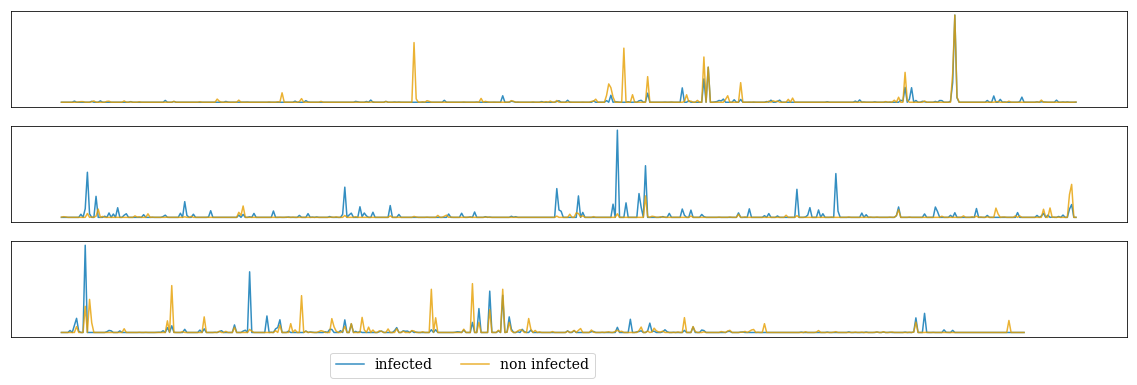

In [24]:
fig, axes = plt.subplots(3,figsize=(20,6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(oneinf.values[470*i:min(470*(i+1), peaks.shape[1])], alpha=0.8, c=colours[5], label='infected')
    ax.plot(onenoninf.values[470*i:min(470*(i+1), peaks.shape[1])], alpha=0.8, c=colours[1], label='non infected')
    ax.set_yticks([])
    ax.set_xticks([])
plt.legend(loc='lower left', bbox_to_anchor=(0.28, -0.5), ncol=2, fontsize=14)

Now the mean of peak intensity across classes.

In [25]:
infmean = infected.mean(axis=0)
noninfmean = noninfected.mean(axis=0)

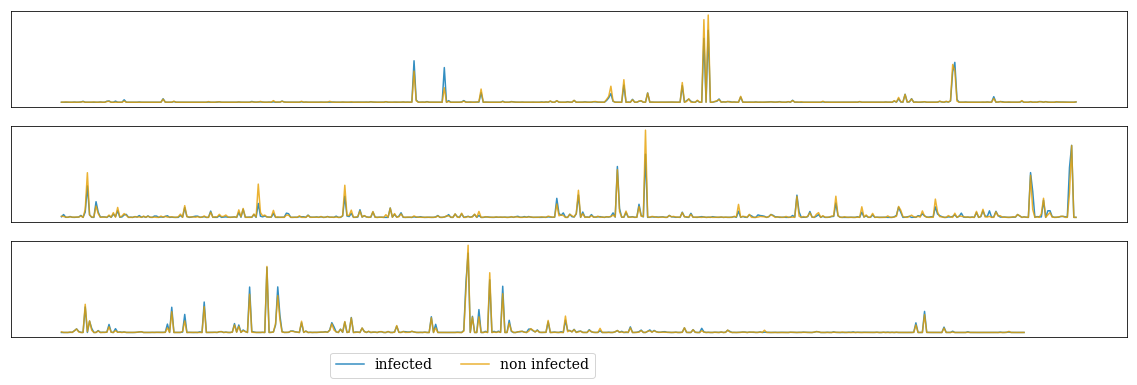

In [26]:
fig, axes = plt.subplots(3,figsize=(20,6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(infmean.values[470*i:min(470*(i+1), peaks.shape[1])], alpha=0.8, c=colours[5], label='infected')
    ax.plot(noninfmean.values[470*i:min(470*(i+1), peaks.shape[1])], alpha=0.8, c=colours[1], label='non infected')
    ax.set_yticks([])
    ax.set_xticks([])
plt.legend(loc='lower left', bbox_to_anchor=(0.28, -0.5), ncol=2, fontsize=14)

### Training a model

In [27]:
CV = KFold(n_splits=10, shuffle=True)
n_splits = CV.get_n_splits(features)

params = {'objective': 'binary', 'learnign_rate': 0.00005}

In [28]:
accuracies = np.array([])
aucs = np.array([])

shap_values = np.zeros((features.shape[0],features.shape[1]+1))

for train_index, test_index in CV.split(features):
    
    X_tr, X_tst = features.values[train_index], features.values[test_index]
    y_tr, y_tst = target[train_index], target[test_index]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
    bst = lgb.train(params, train_set, num_boost_round=500, valid_sets=[train_set, valid_set], early_stopping_rounds=100,
                    verbose_eval=False)
    
    probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
    classes = np.heaviside(probs - 0.5, 1).astype(int)
    
    accuracies = np.append(accuracies, accuracy_score(y_tst, classes))
    aucs = np.append(aucs, roc_auc_score(y_tst, probs))
    
    shap_values += shap.TreeExplainer(bst).shap_values(features.values)/n_splits

In [29]:
print('mean accuracy: %f' %np.mean(accuracies))
print('mean AUC: %f' %np.mean(aucs))

mean accuracy: 0.978442
mean AUC: 0.987401


In [30]:
print('std accuracy: %f' %np.std(accuracies))
print('std AUC: %f' %np.std(aucs))

std accuracy: 0.021564
std AUC: 0.019630


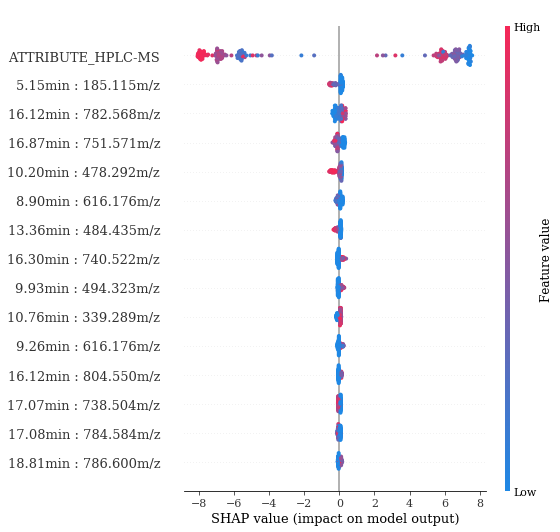

In [31]:
shap.summary_plot(shap_values, features, max_display=15, plot_type='dot')

The feature `HPLC-MS` has the largest influence on the outcome of the predictions. **What is this? Is is a leakage?**  
Let's take a look at it.

In [32]:
infh = features['ATTRIBUTE_HPLC-MS'][target==1]
noninfh = features['ATTRIBUTE_HPLC-MS'][target==0]

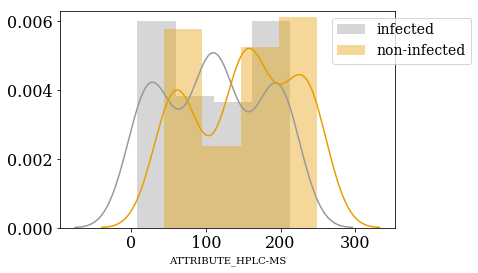

In [33]:
sns.distplot(infh, label='infected')
sns.distplot(noninfh, label='non-infected')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.), fontsize=14)

Text(0.5,0,'row of table')

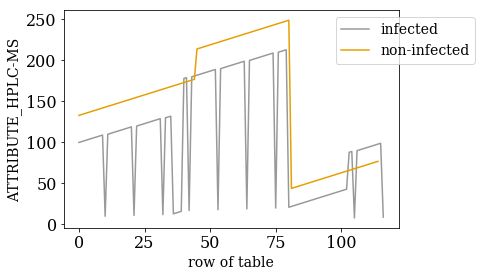

In [34]:
plt.plot(infh.values, label='infected')
plt.plot(noninfh.values, label='non-infected')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.), fontsize=14)
plt.ylabel('ATTRIBUTE_HPLC-MS', fontsize=14)
plt.xlabel('row of table', fontsize=14)

Are the rows of the data ordered? The increasing trend of this feature does not look like a property of the samples. It is probably a leakage.

What if we retrain the model without this feature?

In [35]:
features = features.drop(['ATTRIBUTE_HPLC-MS'], axis=1)

In [36]:
CV = KFold(n_splits=10, shuffle=True)
n_splits = CV.get_n_splits(features)

params = {'objective': 'binary', 'learnign_rate': 0.00005}

In [37]:
accuracies = np.array([])
aucs = np.array([])

shap_values = np.zeros((features.shape[0],features.shape[1]+1))

for train_index, test_index in CV.split(features):
    
    X_tr, X_tst = features.values[train_index], features.values[test_index]
    y_tr, y_tst = target[train_index], target[test_index]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
    bst = lgb.train(params, train_set, num_boost_round=500, valid_sets=[train_set, valid_set], early_stopping_rounds=100,
                    verbose_eval=False)
    
    probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
    classes = np.heaviside(probs - 0.5, 1).astype(int)
    
    accuracies = np.append(accuracies, accuracy_score(y_tst, classes))
    aucs = np.append(aucs, roc_auc_score(y_tst, probs))
    
    shap_values += shap.TreeExplainer(bst).shap_values(features.values)/n_splits

In [38]:
print('mean accuracy: %f' %np.mean(accuracies))
print('mean AUC: %f' %np.mean(aucs))

mean accuracy: 0.585870
mean AUC: 0.624416


In [39]:
print('std accuracy: %f' %np.std(accuracies))
print('std AUC: %f' %np.std(aucs))

std accuracy: 0.081760
std AUC: 0.100366


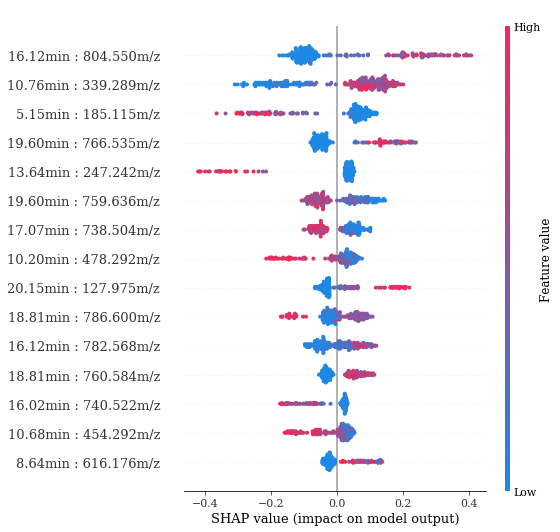

In [40]:
shap.summary_plot(shap_values, features, max_display=15, plot_type='dot')

Per gut section

In [100]:
gsam = features[features.ATTRIBUTE_Gut_section==0].drop(['ATTRIBUTE_Gut_section'], axis=1)
gspm = features[features.ATTRIBUTE_Gut_section==2].drop(['ATTRIBUTE_Gut_section'], axis=1)
gsh = features[features.ATTRIBUTE_Gut_section==1].drop(['ATTRIBUTE_Gut_section'], axis=1)

AM

mean accuracy: 0.819643
mean AUC: 0.885833
std accuracy: 0.129375
std AUC: 0.091443


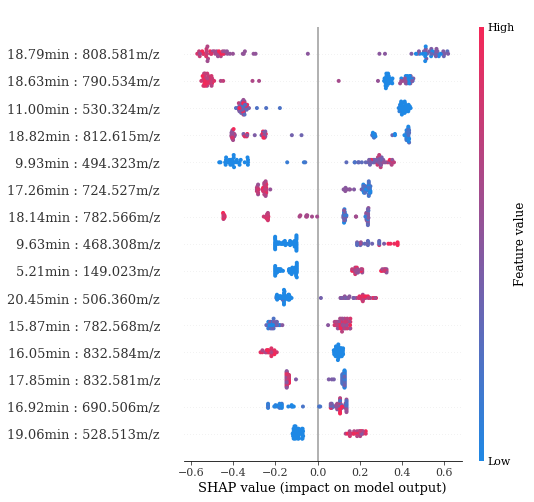

PM

mean accuracy: 0.880357
mean AUC: 0.941667
std accuracy: 0.138563
std AUC: 0.087321


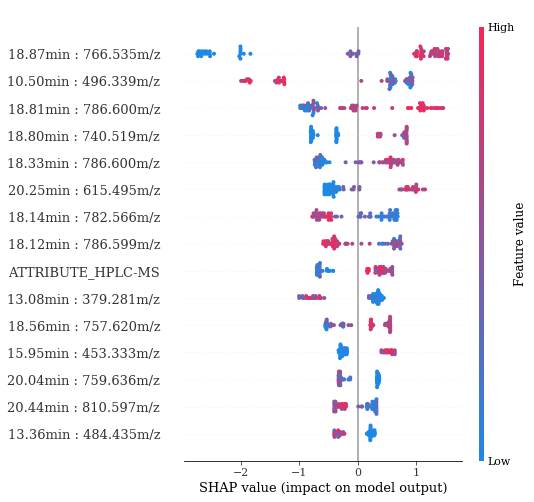

H

mean accuracy: 0.787500
mean AUC: 0.915833
std accuracy: 0.126886
std AUC: 0.090404


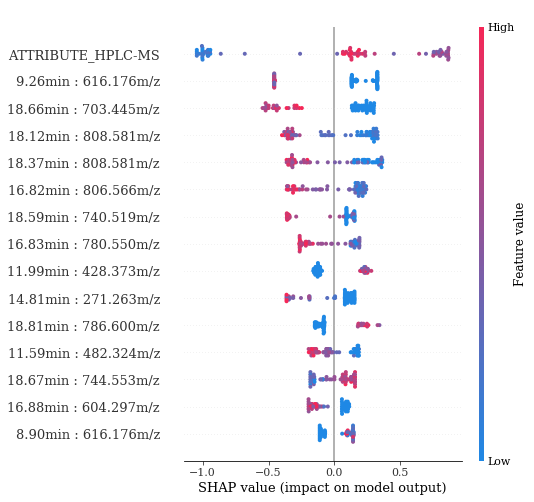

In [101]:
labels = ['AM', 'PM', 'H']

for i, gut_section in enumerate([gsam, gspm, gsh]):
    CV = KFold(n_splits=10, shuffle=True)
    n_splits = CV.get_n_splits(gut_section)

    params = {'objective': 'binary', 'learnign_rate': 0.00005}
    
    accuracies = np.array([])
    aucs = np.array([])

    shap_values = np.zeros((gut_section.shape[0],gut_section.shape[1]+1))

    for train_index, test_index in CV.split(gut_section):
    
        X_tr, X_tst = gut_section.values[train_index], gut_section.values[test_index]
        y_tr, y_tst = target[train_index], target[test_index]
    
        train_set = lgb.Dataset(X_tr, label=y_tr)
        valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
        bst = lgb.train(params, train_set, num_boost_round=500, valid_sets=[train_set, valid_set], early_stopping_rounds=100,
                    verbose_eval=False)
    
        probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
        classes = np.heaviside(probs - 0.5, 1).astype(int)
    
        accuracies = np.append(accuracies, accuracy_score(y_tst, classes))
        aucs = np.append(aucs, roc_auc_score(y_tst, probs))
    
        shap_values += shap.TreeExplainer(bst).shap_values(gut_section.values)/n_splits
        
        
    print(labels[i]+'\n')
    print('mean accuracy: %f' %np.mean(accuracies))
    print('mean AUC: %f' %np.mean(aucs))
    
    print('std accuracy: %f' %np.std(accuracies))
    print('std AUC: %f' %np.std(aucs))
    
    shap.summary_plot(shap_values, gut_section, max_display=15, plot_type='dot')